## Machine Learning notebook (sklearn models)

In this notebook, we will make use of the cleaned data from the previous stage to build two simple machine learning models (**Naive Bayes** and **Logistic Regression**) using `sklearn` package. A more detailed outline of this notebook:
- Data encoding: transform textual data into TF-IDF vectors. We will also perform some additional feature selection process to ensure that the size of the input vectors is suitable with our goal while fit the machine's power.  
- Naive Bayes model: build Naive Bayes model and tune its hyperparameters. 
- Logistic Regression model: build Logistic Regression model and tune its hyperparameters. 
- Model evaluation and comparison: compare the tuned models using various metrics.

### Importing packages

In [1]:
# utils
import numpy as np
import matplotlib.pyplot as plt

# nltk
import nltk
from nltk.tokenize import word_tokenize

# sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import chi2, SelectPercentile

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc

### Data encoding

Let us begin by loading the cleaned data into `X`, `y` - the feature vector and the target vector, respectively.

In [2]:
X = np.load('../data/preprocessed_data/feature_vectors_neg.npy', allow_pickle=True)
y = np.load('../data/preprocessed_data/target_vectors_neg.npy', allow_pickle=True)

We will now split the data into train and test set in 90:10 ratio. Given that the data set is relatively large, it is possible to spend more data for training while still having enough for evaluation. Moreover, considering that we may encounter OVVs (out-of-vocabulary words) - words appeared in the training vocabulary but not in the testing vocabulary - during the vectorizing and evaluating process, the data split ratio may also help to minimize this issue.

In [3]:
X_train_un, X_test_un, y_train_un, y_test_un = train_test_split(X, y, train_size=0.9, random_state=13)

print("Train set size:", X_train_un.shape[0])
print("Test set size", X_test_un.shape[0])

Train set size: 1432053
Test set size 159118


Moving on to the main part, we will now vectorize our data using TF-IDF (term frequency–inverse document frequency). The basic idea of this method is combining the importance of a word in a document (measured by term frequency) and in the whole corpus (measured by inverse document frequency) to produce a overall weight of a term:

$$
\text{tfidf}(t, d, C) = \text{tf}(t, d) \cdot \text{idf}(t, C)
$$

Measuring the term frequency (TF) gives us an idea of how important the word is relative to the document itself. However, if the word's frequency accross documents in the whole corpus is also high (DF), the term will be assumed to be less important and the TF value will get penalized by multiplying with the inverse of DF (IDF). 

In addition, we will combine 2-gram by counting TF-IDF of not only single-word terms (unigrams) but also two-word terms (bigrams). This is a common method to try to expand the vocabulary with sequences that are potentially more relevant and informative than just unigrams.

Let us first vectorize the train and test set using bigram TF-IDF. A small notice here is that the vectorizer must be fit only on the train data, but not the test data. During the feature engineering process, we would always want to prevent any *data leakage* from the test set to the train set, as this will cause the model to learn some information from the test set, which essentially leads to overfitting when tested.

In [4]:
# Initiate bigram TF-IDF vectorizer with our customed tokenizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenize, ngram_range=(1, 2), lowercase=False, max_features=1000000)

# Transform X into vectorized values
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train_un)
X_test_vectorized = tfidf_vectorizer.transform(X_test_un)

One can see that the maximum features has been limited to 1 million. This limit will make the model to only choose the 1 million most frequent words in the corpus, ensuring that the terms are generally more relevant. Without this limit, everything will be taken into the TF-IDF count, including many non-sensical and insignificant words (given that the data is from Twitter), causing noise to the training process and may potentially bias the model (overfitting). There is really no hard-written principle to choose the maximum features, it is just simply repeated experiments of multiple values to see which one works best. 

We may continue by further standardize the target labels ('0' for negative and '4' for positive) into '0' for negative and '1' for positive. The `LabelEncoder` will do this for us automatically:

In [5]:
# Initiate the label encoder to convert target data into (0, 1) instead of (0, 4)
label_encoder = LabelEncoder()
# Transform y into numerical values (0, 1)
y_train = label_encoder.fit_transform(y_train_un)
y_test = label_encoder.transform(y_test_un)

Before putting the vectorized feature vectors into use, we will perform additional feature selection to limit further the size of our vocabulary. Here, we would like to use the *chi-squared test* of independence. Basically, it measures the statistical significance of the correlation between a feature (term) and the label in the form of scores. Features with lowest scores are considered to be less relevant and meaningful to their classified label and will be removed. The test is useful in reducing sparsity and dimensionality of the feature vectors, helping our models to process quicklier. 

Let us use chi-squared test to remove only 10% least relevant terms:

In [6]:
# Initiate chi2 test 
chisquared_test = SelectPercentile(chi2, percentile=90)
chisquared_test.fit(X_train_vectorized, y_train)

# Transform training and test set using fitted chi2 test
X_train = chisquared_test.transform(X_train_vectorized)
X_test = chisquared_test.transform(X_test_vectorized)

### Naive Bayes model

Now that the data is preprocessed and ready to be loaded, we begin to build our very first model **Naive Bayes**. It is a very common choice when one needs to prioritize simplicity over performance in text processing.

The Naive Bayes model is a *generative classifier*, meaning that it tries to model how **all classes** would most likely to generate the given input data. Mathematically, this is done by estimating the correct probability from all classes for each document:
$$
\hat{c} = \underset{c \in C}{\text{argmax}}\ P(c|d) = \underset{c \in C}{\text{argmax}}\ P(d|c) \cdot P(c) \ \text{(Bayes rule)}
$$

Each document $d$, as we know, is represented by multiple features (in this case, TF-IDF score of each word in the vocabulary): $f_1, ..., f_n$. We now have:
$$
\hat{c} = \underset{c \in C}{\text{argmax}}\ P(f_1, ..., f_n|c) \cdot P(c)
$$
Now, we follow a very strong assumption, which is also the core and *naive* part of this algorithm (because it does not often hold): all features are indepedent to each other. Therefore:
$$
P(f_1, ..., f_n|c) = P(f_1|c) \cdot P(f_1|c) \cdot ... \cdot P(f_n|c) 
$$
The probabilities can now be estimated easily by counting how often each feature $f_n$ belongs to each class $c$ given the document.

Moving on to the technical part, we may approach this by using `MultinomialNB` model by `sklearn`. However, we are not going to jump straight into declaring the classifier and training with some random paramaters. Instead, we would like to tune the parameters during the training process. For this, exhaustive grid search will be performed, which considers each of the parameters combinations and compare them using cross-validation and allow us to estimate the best parameters for our model. Building a robust model relies not only on the data but the choice of parameters itself, so tuning them are an important task to consider.

In [7]:
# Declare the Naive Bayes model
nb_clf = MultinomialNB()

# Declare the set of parameters for GridSearch
params = {'alpha': (1e-3, 0.01, 0.1, 1)}

Here, we would like to try different values for alpha, the Laplace smoothing parameters to avoid zero probability in Naive Bayes. This parameter is added to the calculation of the probability of $P(f|c)$ to avoid it being zero (which makes the whole product $P(f_1|c) \cdot P(f_1|c) \cdot ... \cdot P(f_n|c)$ zero). We choose the values 0.001, 0.01, 0.1, 1, reflecting different degree of smoothing. 

We can now begin fitting this on the training set using a 5-fold cross-validation and choose the best classifier using the accuracy metric. 

In [8]:
# Perform Grid Search
nb_grid = GridSearchCV(nb_clf, params, scoring='accuracy', n_jobs=-1, cv=5)
nb_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': (0.001, 0.01, 0.1, 1)}, scoring='accuracy')

The best classifier can be obtained using the `best_estimator_` attributed. The model will be saved for the evaluation stage.

In [9]:
best_nb_clf = nb_grid.best_estimator_
best_nb_clf

MultinomialNB(alpha=1)

### Logistic Regression model

Being a *deterministic classifier*, the Logistic Regression focuses towards discriminating between the classes, rather than learning about all of them. The classifier aims to learn a weight vector $w = [w_1, w_2, ..., w_n]$ and a bias term $b$ to create a simple linear function to make its decision based on the feature vector $X = [f_1, f_2, ..., f_n]$:
$$
z = w*X + b
$$
This process is alike to Linear Regression. But here is now the core part of Logistic Regression: we would like to model the output $z$, representing the decision of the model, into a probability using the *sigmoid function* $\sigma$:
$$
\sigma (z) = \frac{1}{1-e^{-z}}
$$
The sigmoid function will map the linear decision $z$ into a probability between 0 and 1, therefore representing the probability of the input belonging to a class (e.g. high probability means that it belongs to label 1, while low probability means that it belongs to label 0). 

To build our model in sklearn, we can use `LogisticRegression` class from `sklearn`. Here, we would also like to tune the model using a set of two types of parameter. The `solver` is our choice of the algorithm to use in the optimization problem. Here we would like to put into test `saga` and `sag`, the solvers recommended by `sklearn` for large data. The parameter `C` is called the *regularization parameter*, In the Logistic Regression problem, especially with a large number of features, is highly prone to overfitting to the training data due to how it is learned (the more feature, the easier it is to predict which input belongs to which class). Because of this, we need to regularization parameter to penalize the loss function of the model to avoid this. We can choose 4 parameters representing different degree of regularization for `C` to see which one works best. 

In [10]:
logis_clf = LogisticRegression(random_state=13)
params = {
  'C': (1, 5, 10, 50),
  'solver': ('saga', 'sag')
  }

Now, we can perform exhaustive grid search once again to obtain the model with the best parameters using another 5-fold cross validation and based on accuracy.

In [11]:
logis_grid = GridSearchCV(logis_clf, params, scoring='accuracy', n_jobs=-1, cv=5)
logis_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=13), n_jobs=-1,
             param_grid={'C': (1, 5, 10, 50), 'solver': ('saga', 'sag')},
             scoring='accuracy')

Let us also save the best model for the later evaluation stage.

In [12]:
best_logis_clf = logis_grid.best_estimator_
best_logis_clf

LogisticRegression(C=1, random_state=13, solver='saga')

### Model evaluation and comparison



For this final stage of the notebook, we want to evaluate the obtained classifiers using `sklearn` classification report and ROC (Receiver operating characteristic) curve and the AUC (Area under the curve) score. The classification report shows us insights of various metrics, and will be applied to evaluate the model's performance on training and testing data. The ROC curve, on the other hand, will help us understand how well the model can discriminate between the two classes at different *classification thresholds*. The metrics we obtain (precision, accuracy, etc.) depends on the classification results, which in turn depends on the chosen classification thresholds of the model (the default value is 0.5) and may not fully represent how the model performs. Lastly, the AUC score, as its name, measure the overall performance on all thresholds. 

Let us now create a function to print the classification report, as well as plot the ROC curve given a model.

In [13]:
def evaluation_report(model):
  # ---------- Classification report ------------
  # Obtain the predictions for train and test set
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)

  # Print classification report for train set
  print('Training set classification report')
  print(classification_report(y_train, y_pred_train))

  # Print classification report for test set
  print('Testing set classification report')
  print(classification_report(y_test, y_pred_test))

  # ---------------- ROC curve --------------------
  # Obtain one side of the prediction as probabilities
  y_pred_proba = model.predict_proba(X_test)[:, 1]
  # Obtain metrics for plotting
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

  # Compute AUC score
  auc_score = auc(fpr, tpr)

  # Plot ROC curve 
  print('ROC curve')
  plt.plot(fpr, tpr) 
  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (AUC = %0.2f)' % auc_score)
  plt.show()

We can now apply the function to the Naive Bayes and Logistic Regression model obtained from the previous stages:

Training set classification report
              precision    recall  f1-score   support

           0       0.86      0.86      0.86    716445
           1       0.86      0.86      0.86    715608

    accuracy                           0.86   1432053
   macro avg       0.86      0.86      0.86   1432053
weighted avg       0.86      0.86      0.86   1432053

Testing set classification report
              precision    recall  f1-score   support

           0       0.79      0.80      0.79     79536
           1       0.80      0.79      0.79     79582

    accuracy                           0.79    159118
   macro avg       0.79      0.79      0.79    159118
weighted avg       0.79      0.79      0.79    159118

ROC curve


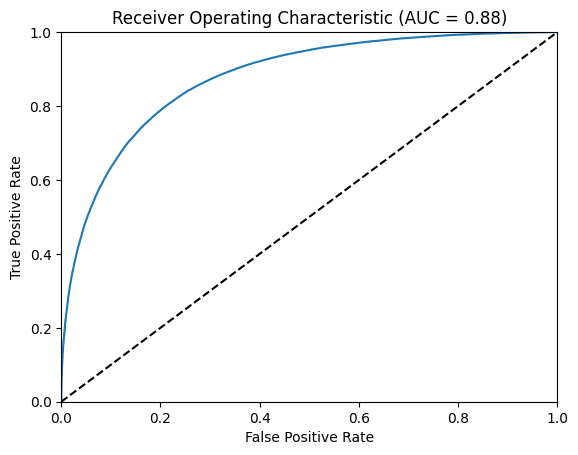

In [14]:
evaluation_report(best_nb_clf)

Training set classification report
              precision    recall  f1-score   support

           0       0.86      0.84      0.85    716445
           1       0.84      0.86      0.85    715608

    accuracy                           0.85   1432053
   macro avg       0.85      0.85      0.85   1432053
weighted avg       0.85      0.85      0.85   1432053

Testing set classification report
              precision    recall  f1-score   support

           0       0.82      0.80      0.81     79536
           1       0.80      0.82      0.81     79582

    accuracy                           0.81    159118
   macro avg       0.81      0.81      0.81    159118
weighted avg       0.81      0.81      0.81    159118

ROC curve


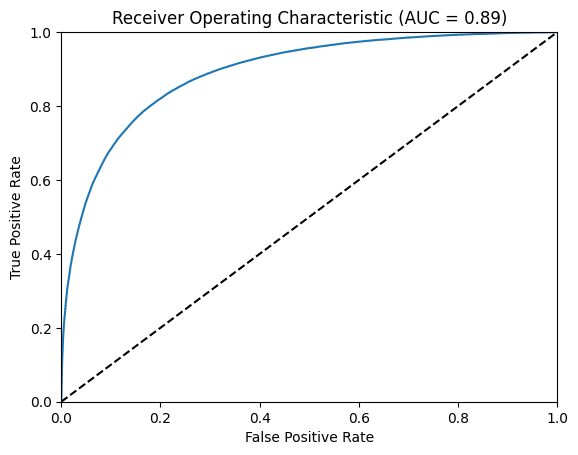

In [15]:
evaluation_report(best_logis_clf)

The classification report of the training data shows us how the model performs during training given the best parameters. A common mistake is to think that it represent the predictive ability of the model. Based on the computed metrics, we can see that the Naive Bayes model is able to fit on the training data slightly better than the Logistic Regression model, given that all the metrics are all higher. This may be explained by the fact that the Logistic Regression is tightly regularized (`C` = 1) to prioritize better generalization. 

In the opposite, the metrics for the testing data reveal that the Logistic Regression model is better than the Naive Bayes model in terms of predicting ability. The Logistic Regression model is able to catch 82% of all the actual positive (recall), while hitting 80% positives of all the predicted positives (precision) and have a good balance between the two metrics (F1). Overall, it achieves 81% accuracy. For Naive Bayes, all of the metrics are either lower or equal to Logistic Regression, overall hitting only 79% accuracy. This behavior can be expected, given that the Naive Bayes model is usually considered inferior to deterministic models such as Logistic Regression due to its very strong assumption, which does not hold in real life context.

The predictive power on all classification thresholds is given by the ROC curve and the AUC score also gives the same result: the Logistic Regression model performs slightly better than the Naive Bayes model.

Although both models showcases that their performance are quite good despite such a large corpus and vocabulary of words, the Logistic Regression one proves to be more robust than Naive Bayes. This goes to show how important feature selection and data cleaning is for achieving reliable results during training. We can now finally conclude this notebook. 